# 3 Unsupervised Learning
Background. In this part, you will implement self-taught learning using an Autoencoder and a
3-layer Neural Network to solve a multi-class classification task on real-world data

Question 3 [Self-supervised Neural Network Learning, 2+5+2+5+5+6=25 Marks]

Load Task2C labeled.csv, Task2C unlabeled.csv, and Task2C test.csv datasets, along with
the required libraries. Note that we will use both Task2C labeled.csv and Task2C unlabeled.csv
to train the autoencoder, and only Task2C labeled.csv to train the classifiers. Finally, we will
evaluate the trained classifier on the test dataset Task2C test.csv.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from  scipy.stats import multivariate_normal
from zipfile import ZipFile
from sklearn.preprocessing import normalize
import re
import pandas as pd
import os

In [4]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
dir = '/content/drive/MyDrive/FIT5201/Assignment2'
text_path = os.path.join(dir, 'Task2C_labeled.csv')
labeled = pd.read_csv(text_path)
text_path = os.path.join(dir, 'Task2C_unlabeled.csv')
unlabeled = pd.read_csv(text_path)
text_path = os.path.join(dir, 'Task2C_test.csv')
test = pd.read_csv(text_path)

Copy helper functions provided in Activiy 5 folder

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import torch
from torch import tensor
from torch.optim import Adam
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


def show_images(images, labels = None, size=(28,28), rows = 1, scale=4):
    """Display a list of images in a single figure with matplotlib.

    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.

    rows (Default = 1): Number of columns in figure (number of cols is
                        set to np.ceil(n_images/float(rows))).

    labels: List of labels corresponding to each image. Must have
            the same length as images.

    scale: Scale factor for image display
    """
    assert((labels is None)or (len(images) == len(labels)))
    n_images = len(images)
    if labels is None:
        labels = ['Image (%d)' % i for i in range(1,n_images + 1)]
    else:
        labels = ['Label: (%d)' % i for i in labels]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, labels)):
        image = image.reshape(size)
        cols=int(np.ceil(n_images/float(rows)))
        a = fig.add_subplot(rows, cols , n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/scale)
    plt.show()

def moving_average(alist, window_size=3):
    numbers_series = pd.Series(alist)
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()

    moving_averages_list = moving_averages.tolist()
    return(moving_averages_list[window_size - 1:])


def normalize(x, m=None, s=None):
    if m is None or s is None:
        #print('Normalizing data: No mean and/or sd given. Assuming it is training data')
        m,s = x.mean(), x.std()

    return (x-m)/s

def get_dataloader(X_train,Y_train=None, autoencoder=False,bs=128, standardize=True, return_dataset=False):
    """
    Retrieves a data loader to use for training. In case autoencoder=True, Y_train automatically is set to X_train
    The function returns the dataloader only if return_dataset is False otherwise it returns a tuple (dataloader,train_dataset)
    where train_dataset is the Dataset object after preprocessing.
    """
    try:
        X_train= np.array(X_train).astype(np.float32)
        if standardize: X_train = normalize(X_train)
        if not autoencoder: Y_train = np.array(Y_train)
    except Exception as e:
        raise Exception('Make sure your input and labels are array-likes. Your input failed with exception: %s'%e)
    # transform into tensors
    if autoencoder:
        Y_train = X_train

    X_train, Y_train = map(tensor, (X_train, Y_train))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    train_ds = TensorDataset(X_train,Y_train)
    train_dl = DataLoader(train_ds, batch_size=16)

    if return_dataset: return train_dl,train_ds

    return train_dl

def train_autoencoder(X_train,hidden,activation='Tanh',epochs=10, trace=True, **kwargs):
    """
    Trains an Autoencoder and returns the trained model

    Params:
    X_train: Input data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)

    hidden: a list of sizes for the hidden layers ex: ([100,2,100]) will train an autoencoder with 3 layers

    activation (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation

    epochs: Number of epochs to train autoencoder

    trace: if true, will display epoch progress and will plot the loss plot at the end of training

    **kwargs: passed to Adam optimizer, lookup adam optimizer for more details
    """
    train_dl = get_dataloader(X_train,autoencoder=True)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = n_inps
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')

    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])

    layers.pop()  # to remove the last non-linearity

    model = nn.Sequential(*layers)
    model = model.to(device)
    print('Training Model on %s'%(device))
    # to capture training loss
    losses = []
    epoch_losses = []
    # define optimizer with learning rate
    optim = Adam(model.parameters(), **kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.MSELoss()
    # calculate printing step - optional
    printing_step = int(epochs/10)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_criterion(preds,yb)
            losses.append(loss.item())
            loss.backward()
            optim.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
        if trace and not epoch%printing_step:
            print(f'Epoch {epoch} out of {epochs}. Loss:{epoch_loss}')

    if trace:
        plt.figure()
        plt.plot(epoch_losses)
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.title('Training loss')
        plt.show()
    return model


def train_classifier(X_train,Y_train,hidden,activation='Tanh',epochs=10, trace=True,**kwargs):
    """
    Trains a feedforward classifier and returns the trained model

    Params:
    X_train: Training data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)

    Y_train: Training labels. Can be a Series, 1D numpy array, 1-D list or a tensor with 1 dimension

    hidden: a list of sizes for the hidden layers ex: ([100,2,100]) will train an autoencoder with 3 layers

    activation (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation

    epochs: Number of epochs to train autoencoder

    trace: if true, will display epoch progress and will plot the loss plot at the end of training
    """
    train_dl = get_dataloader(X_train,Y_train,autoencoder=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = [len(Y_train.unique())]   # is not a good idea if you are expecting very large datasets
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')

    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])

    layers.pop()  # to remove the last non-linearity

    model = nn.Sequential(*layers)
    model = model.to(device)
    print('Training Model on %s'%(device))
    # to capture training loss
    losses = []
    epoch_losses =[]
    # define optimizer with learning rate
    optim = Adam(model.parameters(),**kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.CrossEntropyLoss()
    # calculate printing step - optional
    printing_step = int(epochs/10)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_criterion(preds,yb)
            losses.append(loss.item())
            loss.backward()
            optim.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
        if trace and not epoch%printing_step:
            print(f'Epoch {epoch} out of {epochs}. Loss:{epoch_loss}')

    if trace:
        plt.figure()
        plt.plot(moving_average(losses))
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.title('Training loss')
        plt.show()
    return model

def get_deepfeatures(trained_model, X_input,layer_number):
    '''
    Gets deep features of a given `layer_number` upon passing `X_input` through a `trained_model`
    '''
    X_input = get_dataloader(X_input,autoencoder=True,return_dataset=True)[1].tensors[0]
    result = []
    def save_result(m,i,o):
        result.append(o.data)
    hook = trained_model[layer_number].register_forward_hook(save_result)

    with torch.no_grad():
        trained_model(X_input)

    hook.remove()

    return (result[0].cpu().numpy())

We will choose all features in X and label in Y for both label and test datasets provided. As unlabeled doesn't have labels we will just keep everything in X_unlabel

In [7]:
X_label = np.array(labeled.iloc[:,1:])
Y_label = np.array(labeled.iloc[:,0])
X_unlabel = np.array(unlabeled.iloc[:,1:])
X_test = np.array(test.iloc[:,1:])
Y_test = np.array(test.iloc[:,0])

Visualizing some samples

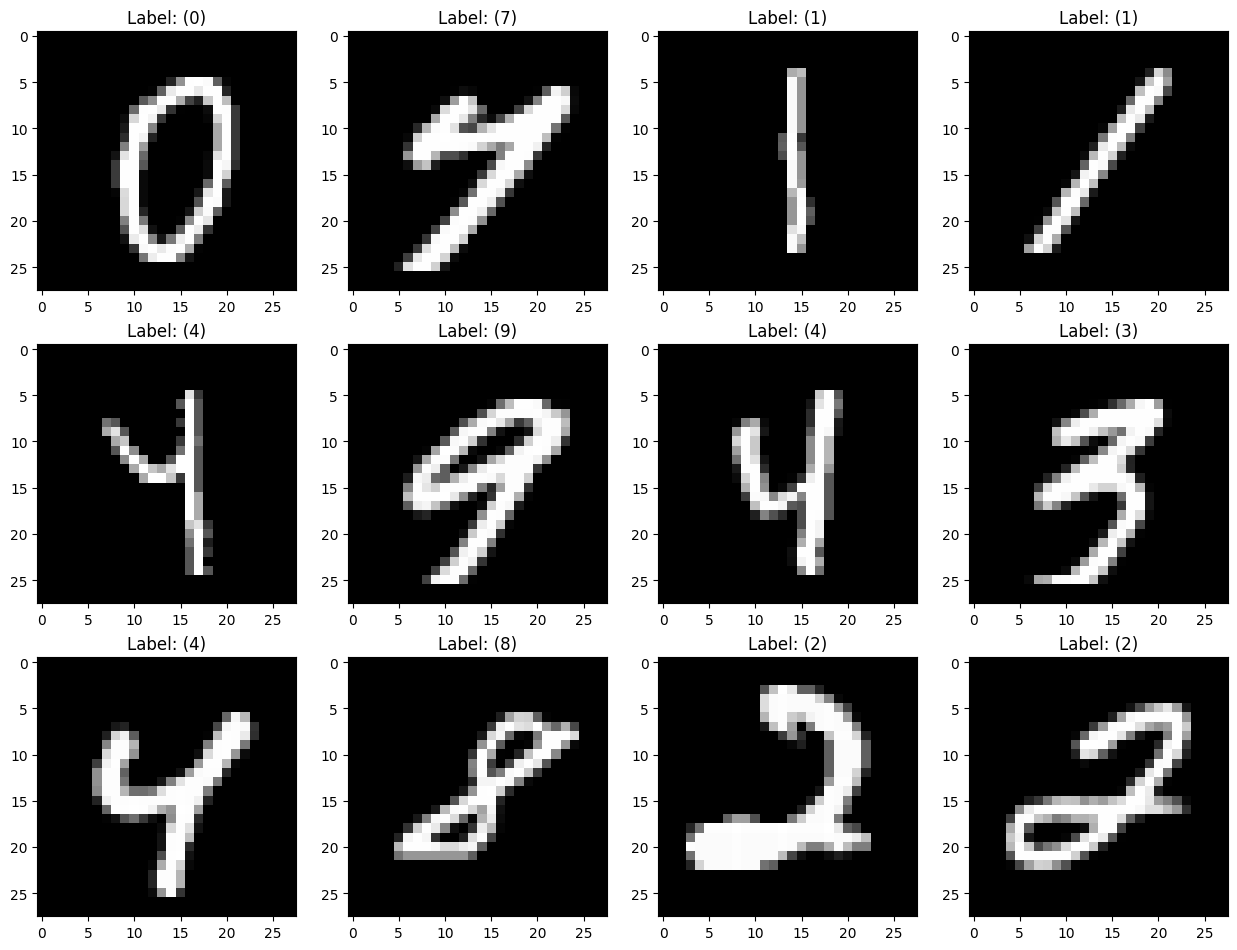

In [8]:
show_images(X_label[:12], Y_label[:12],rows=3, scale=5)

II Train an autoencoder with only one hidden layer and change the number of its neurons to 20,
60, 100, ..., 220 (i.e. from 20 to 220 with a step size of 40).

Here we will train and test both our label

20
Training Model on cpu
Epoch 0 out of 40. Loss:1.1036151051521301
Epoch 4 out of 40. Loss:0.9794389605522156
Epoch 8 out of 40. Loss:0.8775002956390381
Epoch 12 out of 40. Loss:0.7890766710042953
Epoch 16 out of 40. Loss:0.7301401793956757
Epoch 20 out of 40. Loss:0.6897015124559402
Epoch 24 out of 40. Loss:0.6565369516611099
Epoch 28 out of 40. Loss:0.6267683655023575
Epoch 32 out of 40. Loss:0.5996649041771889
Epoch 36 out of 40. Loss:0.5750285238027573


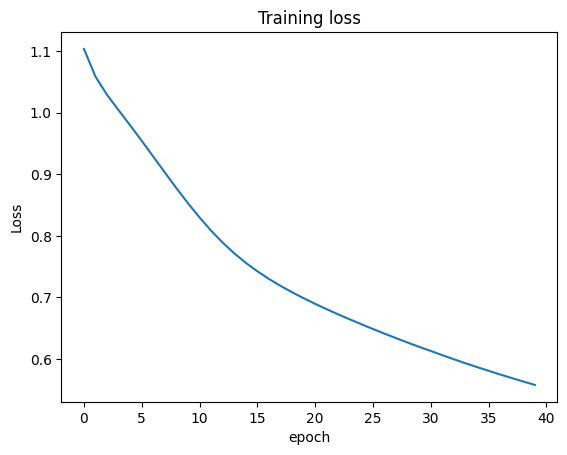

60
Training Model on cpu
Epoch 0 out of 40. Loss:1.0817004144191742
Epoch 4 out of 40. Loss:0.7918605506420135
Epoch 8 out of 40. Loss:0.6420559585094452
Epoch 12 out of 40. Loss:0.5438224077224731
Epoch 16 out of 40. Loss:0.47176872193813324
Epoch 20 out of 40. Loss:0.4190162494778633
Epoch 24 out of 40. Loss:0.3784416150301695
Epoch 28 out of 40. Loss:0.3456390406936407
Epoch 32 out of 40. Loss:0.31812200602144003
Epoch 36 out of 40. Loss:0.29462013952434063


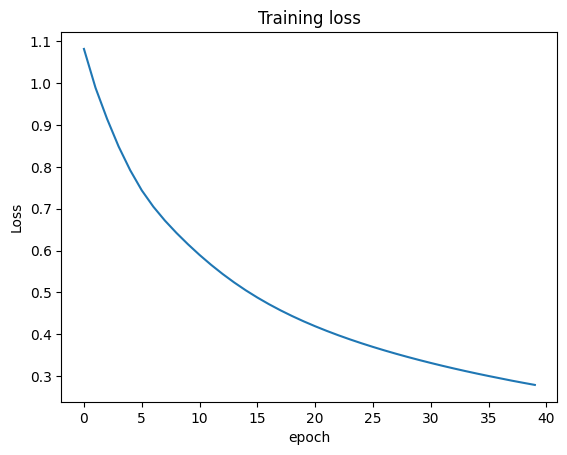

100
Training Model on cpu
Epoch 0 out of 40. Loss:1.0603603720664978
Epoch 4 out of 40. Loss:0.6857542395591736
Epoch 8 out of 40. Loss:0.5269927605986595
Epoch 12 out of 40. Loss:0.4170674793422222
Epoch 16 out of 40. Loss:0.34578144922852516
Epoch 20 out of 40. Loss:0.2969330372288823
Epoch 24 out of 40. Loss:0.2600032784976065
Epoch 28 out of 40. Loss:0.2299827877432108
Epoch 32 out of 40. Loss:0.20456962322350591
Epoch 36 out of 40. Loss:0.1824132374022156


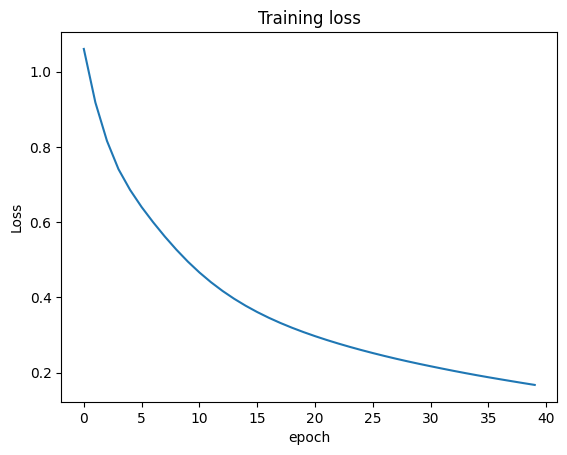

140
Training Model on cpu
Epoch 0 out of 40. Loss:1.0377447605133057
Epoch 4 out of 40. Loss:0.6089520454406738
Epoch 8 out of 40. Loss:0.44058507308363914
Epoch 12 out of 40. Loss:0.33760744892060757
Epoch 16 out of 40. Loss:0.27303949603810906
Epoch 20 out of 40. Loss:0.22735632583498955
Epoch 24 out of 40. Loss:0.19176373450318351
Epoch 28 out of 40. Loss:0.16279973177006468
Epoch 32 out of 40. Loss:0.1388656047929544
Epoch 36 out of 40. Loss:0.11877332656877115


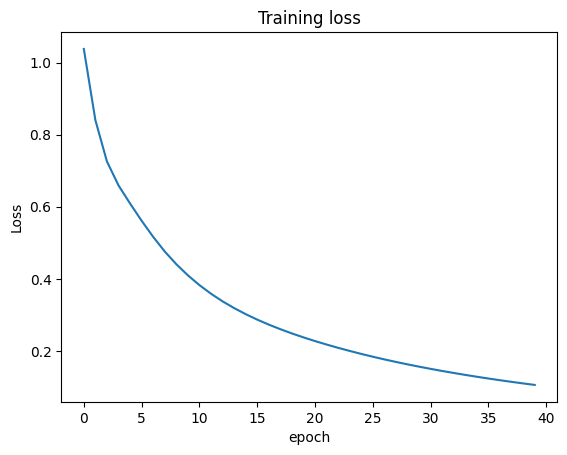

180
Training Model on cpu
Epoch 0 out of 40. Loss:1.0412513613700867
Epoch 4 out of 40. Loss:0.5648677423596382
Epoch 8 out of 40. Loss:0.3782855123281479
Epoch 12 out of 40. Loss:0.28171431412920356
Epoch 16 out of 40. Loss:0.22163273801561445
Epoch 20 out of 40. Loss:0.1784572926699184
Epoch 24 out of 40. Loss:0.1452408104960341
Epoch 28 out of 40. Loss:0.11899705993710086
Epoch 32 out of 40. Loss:0.09783917301683687
Epoch 36 out of 40. Loss:0.08123446319950745


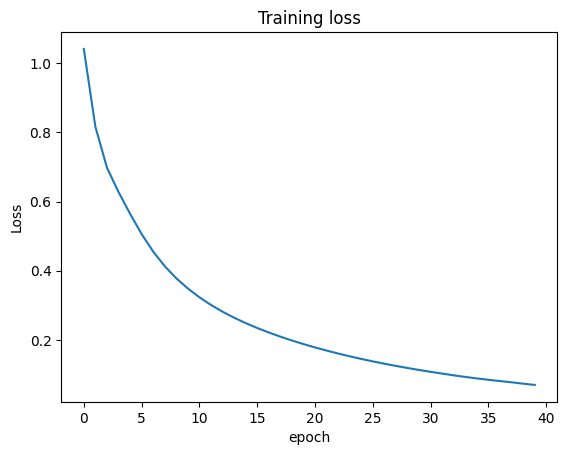

220
Training Model on cpu
Epoch 0 out of 40. Loss:1.0069073885679245
Epoch 4 out of 40. Loss:0.5020315498113632
Epoch 8 out of 40. Loss:0.32156155444681644
Epoch 12 out of 40. Loss:0.2369803562760353
Epoch 16 out of 40. Loss:0.18280624417820945
Epoch 20 out of 40. Loss:0.14262841493473388
Epoch 24 out of 40. Loss:0.11214729124912992
Epoch 28 out of 40. Loss:0.08851853618398309
Epoch 32 out of 40. Loss:0.06986955314641818
Epoch 36 out of 40. Loss:0.055345572473015636


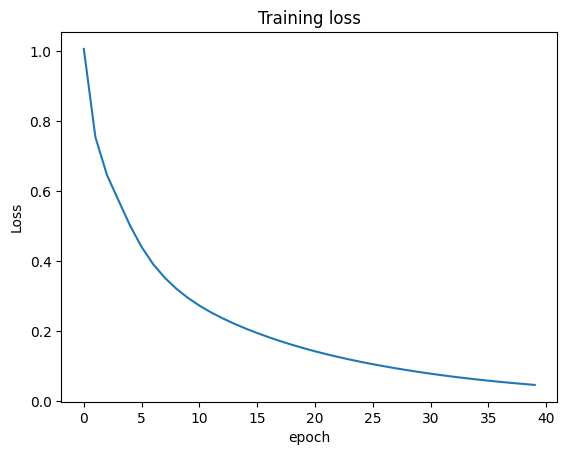

In [15]:
#label Autoencoder

autoencodermodellistlabel=[]
neuron_list=[]
for n in range(20, 260, 40):
    print(n)
    #Here we train the autoencoder with Tanh as the activation function,
    #epoch as 40 and learning rate of 0.001
    AE_model_label = train_autoencoder(
    X_train = X_label,
    hidden = [n],
    epochs = 40,
    activation = 'Tanh',
    lr = 0.001)
    autoencodermodellistlabel.append(AE_model_label)
    neuron_list.append(n)


20
Training Model on cpu
Epoch 0 out of 40. Loss:0.7973254297641997
Epoch 4 out of 40. Loss:0.4600192327448662
Epoch 8 out of 40. Loss:0.37067480607235687
Epoch 12 out of 40. Loss:0.3289656084268651
Epoch 16 out of 40. Loss:0.3145534443728467
Epoch 20 out of 40. Loss:0.2932444336883565
Epoch 24 out of 40. Loss:0.28354748639654603
Epoch 28 out of 40. Loss:0.27757974904268345
Epoch 32 out of 40. Loss:0.2732148736398271
Epoch 36 out of 40. Loss:0.27266236584871373


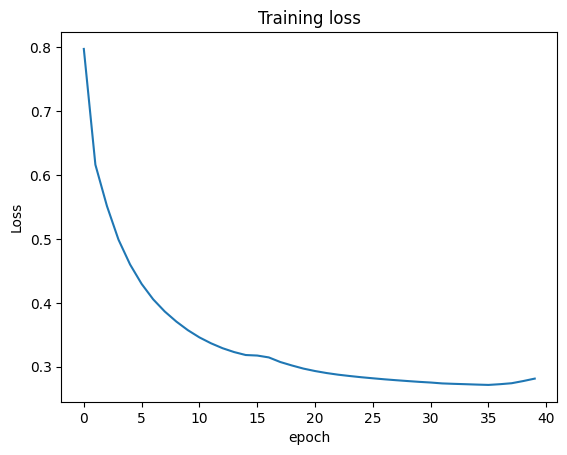

60
Training Model on cpu
Epoch 0 out of 40. Loss:0.6429774815097768
Epoch 4 out of 40. Loss:0.2629049783374401
Epoch 8 out of 40. Loss:0.19908308808473832
Epoch 12 out of 40. Loss:0.16357296245529296
Epoch 16 out of 40. Loss:0.1464154652934125
Epoch 20 out of 40. Loss:0.14594466247140092
Epoch 24 out of 40. Loss:0.1426163063721454
Epoch 28 out of 40. Loss:0.12905583903193474
Epoch 32 out of 40. Loss:0.12641869532935163
Epoch 36 out of 40. Loss:0.13063492086973597


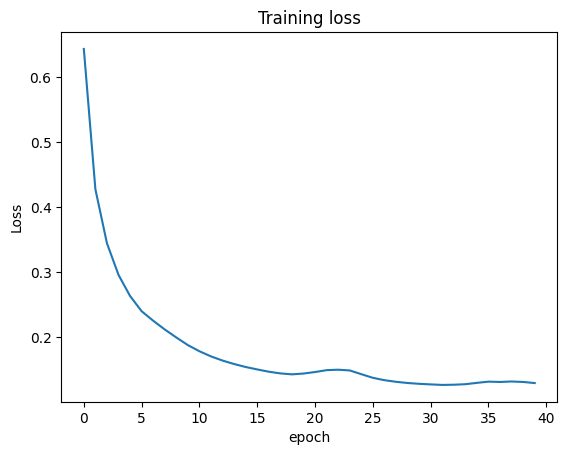

100
Training Model on cpu
Epoch 0 out of 40. Loss:0.5616552709264958
Epoch 4 out of 40. Loss:0.1844337191036407
Epoch 8 out of 40. Loss:0.1371187500338605
Epoch 12 out of 40. Loss:0.10781617034622963
Epoch 16 out of 40. Loss:0.09441225912342681
Epoch 20 out of 40. Loss:0.0973214920055359
Epoch 24 out of 40. Loss:0.0954751542749557
Epoch 28 out of 40. Loss:0.09042782732780943
Epoch 32 out of 40. Loss:0.08198767948023816
Epoch 36 out of 40. Loss:0.07781110030222446


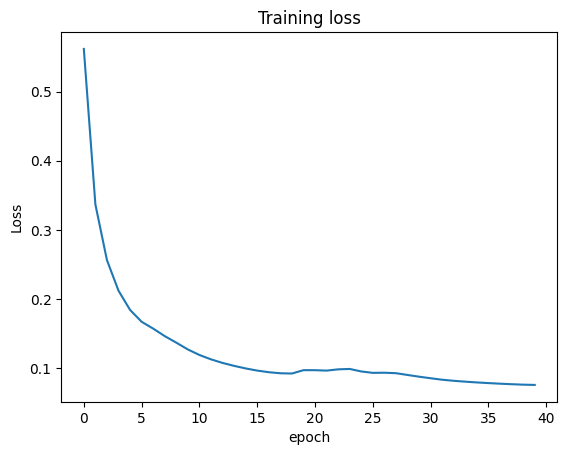

140
Training Model on cpu
Epoch 0 out of 40. Loss:0.5145320689424555
Epoch 4 out of 40. Loss:0.14557602644917814
Epoch 8 out of 40. Loss:0.10620095097321144
Epoch 12 out of 40. Loss:0.0859663669574768
Epoch 16 out of 40. Loss:0.07233969375808189
Epoch 20 out of 40. Loss:0.0724743784187322
Epoch 24 out of 40. Loss:0.07233597365941138
Epoch 28 out of 40. Loss:0.06400513795620584
Epoch 32 out of 40. Loss:0.059354030626251345
Epoch 36 out of 40. Loss:0.058376543461642366


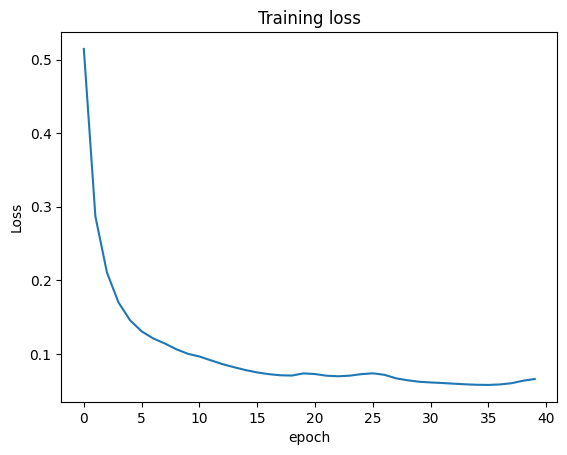

180
Training Model on cpu
Epoch 0 out of 40. Loss:0.4803107754981264
Epoch 4 out of 40. Loss:0.12526271793436497
Epoch 8 out of 40. Loss:0.08584203483893517
Epoch 12 out of 40. Loss:0.07278060282957047
Epoch 16 out of 40. Loss:0.06560661485220523
Epoch 20 out of 40. Loss:0.059654698726978705
Epoch 24 out of 40. Loss:0.0606429221385971
Epoch 28 out of 40. Loss:0.05151111886222312
Epoch 32 out of 40. Loss:0.04679638123575677
Epoch 36 out of 40. Loss:0.050358605115337574


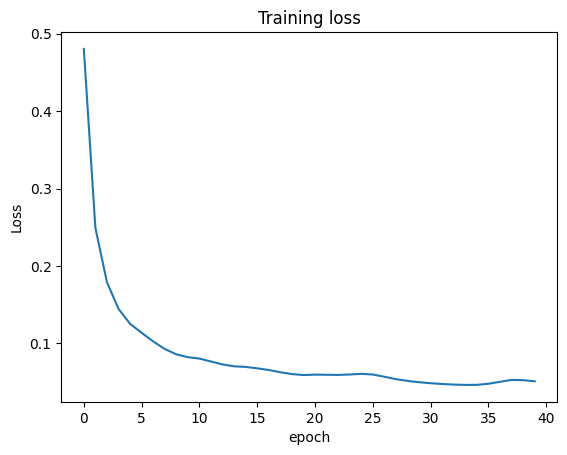

220
Training Model on cpu
Epoch 0 out of 40. Loss:0.4541254465250259
Epoch 4 out of 40. Loss:0.10685223126982121
Epoch 8 out of 40. Loss:0.07833143973604162
Epoch 12 out of 40. Loss:0.06177198700606823
Epoch 16 out of 40. Loss:0.05666646004674283
Epoch 20 out of 40. Loss:0.0474229079294712
Epoch 24 out of 40. Loss:0.051221159980335135
Epoch 28 out of 40. Loss:0.04406472073590502
Epoch 32 out of 40. Loss:0.041338796786805417
Epoch 36 out of 40. Loss:0.04339698904213753


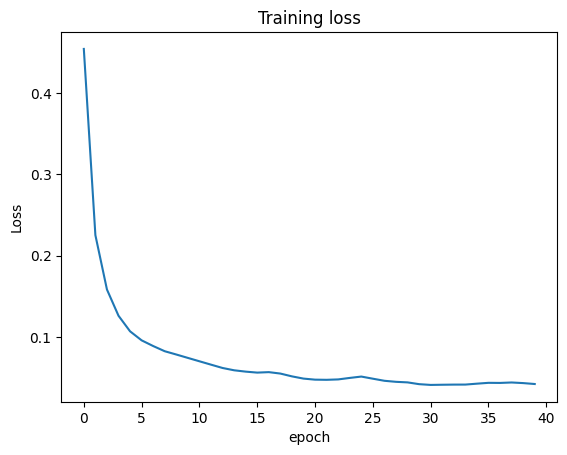

In [16]:
#Unlabel Autoencoder

reconstruction_errors = []
autoencodermodellistunlabel=[]
neuron_list=[]
for n in range(20, 260, 40):
    print(n)
    #Here we train the autoencoder with Tanh as the activation function,
    #epoch as 40 and learning rate of 0.001
    AE_model_unlabel = train_autoencoder(
    X_train = X_unlabel,
    hidden = [n],
    epochs = 40,
    activation = 'Tanh',
    lr = 0.001)
    autoencodermodellistunlabel.append(AE_model_unlabel)
    neuron_list.append(n)


We train the autoencoder with one hidden layer and learning rate of 0.001 and tanh as the activation function with epoch 40

III For each model in Step II, calculate and record the reconstruction error for the autoencoder,
which is simply the average of Euclidian distances between the input and output of the
autoencoder. Plot these values where the x-axis is the number of units in the middle layer
and the y-axis is the reconstruction error. Then, explain your findings based on the plot.

We will caculate the reconstruction error which is the average euclidean distance

In [17]:
reconstruction_errors_label = []
for model in autoencodermodellistlabel:
    #Convert data into tensor
    X_tensor = torch.Tensor(X_label)
    #We get model output
    reconstructed_output_label = model(X_tensor)
    #Calculate error using euclidean distance
    reconstruction_error_label = torch.mean(torch.sqrt(torch.sum((X_tensor - reconstructed_output_label) ** 2, dim=1))).item()
    reconstruction_errors_label.append(reconstruction_error_label)

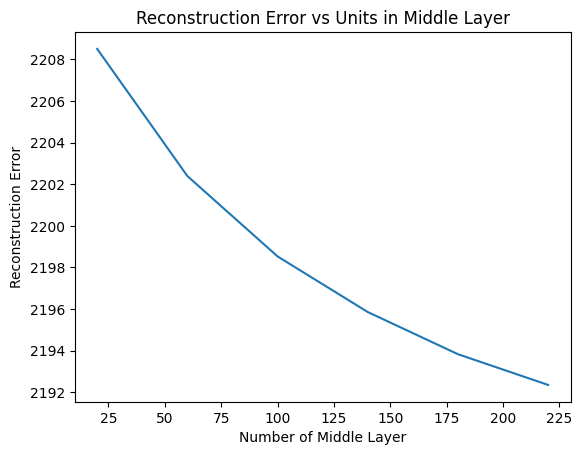

In [21]:
plt.plot(neuron_list, reconstruction_errors_label)
plt.xlabel('Number of Middle Layer')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Units in Middle Layer')
plt.show()

In [22]:
reconstruction_errors_unlabel = []
for model in autoencodermodellistunlabel:
    #Convert data into tensor
    X_tensor = torch.Tensor(X_unlabel)
    #We get model output
    reconstructed_output_unlabel = model(X_tensor)
    #Calculate error using euclidean distance
    reconstruction_error_unlabel = torch.mean(torch.sqrt(torch.sum((X_tensor - reconstructed_output_unlabel) ** 2, dim=1))).item()
    reconstruction_errors_unlabel.append(reconstruction_error_unlabel)

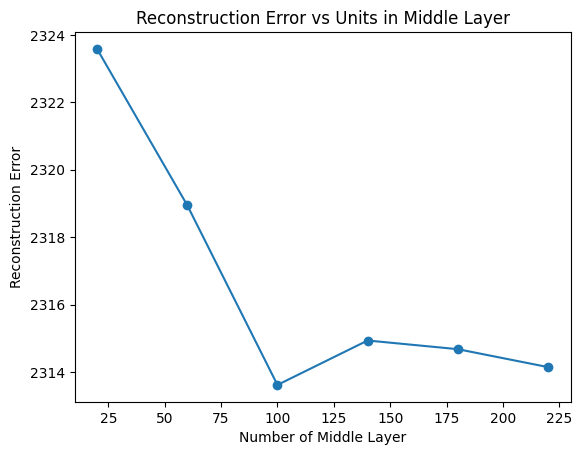

In [23]:
plt.plot(neuron_list, reconstruction_errors_unlabel, marker='o')
plt.xlabel('Number of Middle Layer')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Units in Middle Layer')
plt.show()

We can see a clear decline of reconstruction error for both label and unlabel data. This could be due to caturing complex relationshipas the number of layer increases. More parameters ahave been explored.

We can also see that label datsets have a much smoother decline while the unlabel data drops to its lowes at 100 layers and goes back up. This is dropped back again as the layers are increased. These could be due to overfitting of dataset

IV Build the 3-layer NN to build a classification model using all the original attributes from
the training set and change the number of its neurons to 20, 60, 100, ..., 220 (i.e. from 20 to
220 with a step size of 40). For each model, calculate and record the test error.

Here we will use the label data to calculate the three layer Neural Network. The three layers are defined as n,2,n where n will range from 20 to 220 with step sizeof 40.

We will save all classification models to calculate the errors

In [26]:
X_label = labeled.iloc[:,1:]
Y_label = labeled.iloc[:,0]

Layers:  20 2 20
Training Model on cpu
Epoch 0 out of 40. Loss:2.2619593739509583
Epoch 4 out of 40. Loss:2.0247843265533447
Epoch 8 out of 40. Loss:1.9054315388202667
Epoch 12 out of 40. Loss:1.8017836511135101
Epoch 16 out of 40. Loss:1.7100496888160706
Epoch 20 out of 40. Loss:1.6282728910446167
Epoch 24 out of 40. Loss:1.5541361272335052
Epoch 28 out of 40. Loss:1.4853979051113129
Epoch 32 out of 40. Loss:1.4183956980705261
Epoch 36 out of 40. Loss:1.358105644583702


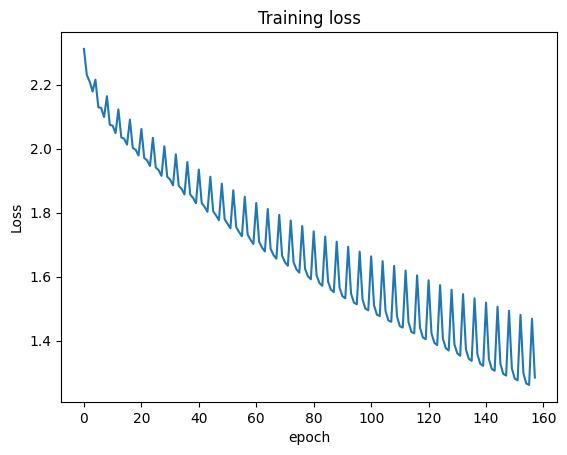

Layers:  60 2 60
Training Model on cpu
Epoch 0 out of 40. Loss:2.2101317644119263
Epoch 4 out of 40. Loss:1.9683647453784943
Epoch 8 out of 40. Loss:1.7589489817619324
Epoch 12 out of 40. Loss:1.6027317345142365
Epoch 16 out of 40. Loss:1.455940306186676
Epoch 20 out of 40. Loss:1.3274560272693634
Epoch 24 out of 40. Loss:1.2145476341247559
Epoch 28 out of 40. Loss:1.1260931491851807
Epoch 32 out of 40. Loss:1.0418514609336853
Epoch 36 out of 40. Loss:0.9759522527456284


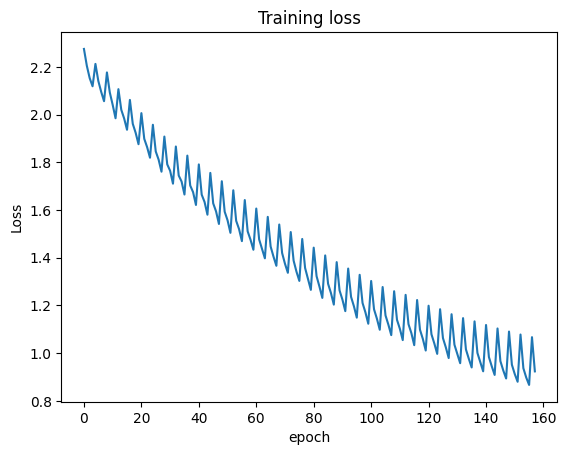

Layers:  100 2 100
Training Model on cpu
Epoch 0 out of 40. Loss:2.3096967339515686
Epoch 4 out of 40. Loss:1.8252627849578857
Epoch 8 out of 40. Loss:1.5401168763637543
Epoch 12 out of 40. Loss:1.3800008893013
Epoch 16 out of 40. Loss:1.2603514790534973
Epoch 20 out of 40. Loss:1.150082767009735
Epoch 24 out of 40. Loss:1.0416066348552704
Epoch 28 out of 40. Loss:0.9246450066566467
Epoch 32 out of 40. Loss:0.8694800138473511
Epoch 36 out of 40. Loss:0.8110402151942253


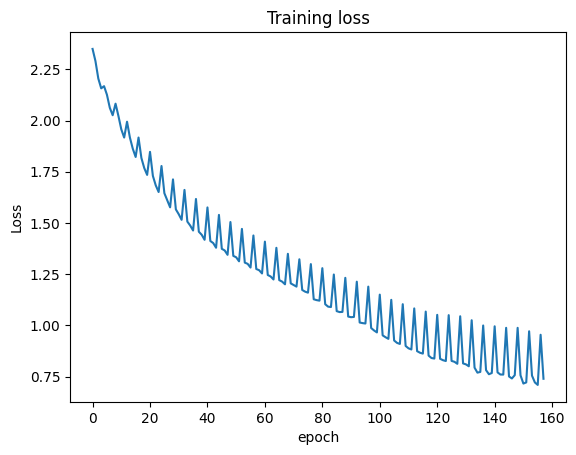

Layers:  140 2 140
Training Model on cpu
Epoch 0 out of 40. Loss:2.268389582633972
Epoch 4 out of 40. Loss:1.8489512205123901
Epoch 8 out of 40. Loss:1.4999145567417145
Epoch 12 out of 40. Loss:1.2047073394060135
Epoch 16 out of 40. Loss:1.0356893613934517
Epoch 20 out of 40. Loss:0.9596247859299183
Epoch 24 out of 40. Loss:0.8845455683767796
Epoch 28 out of 40. Loss:0.8331721276044846
Epoch 32 out of 40. Loss:0.7867176756262779
Epoch 36 out of 40. Loss:0.7585188746452332


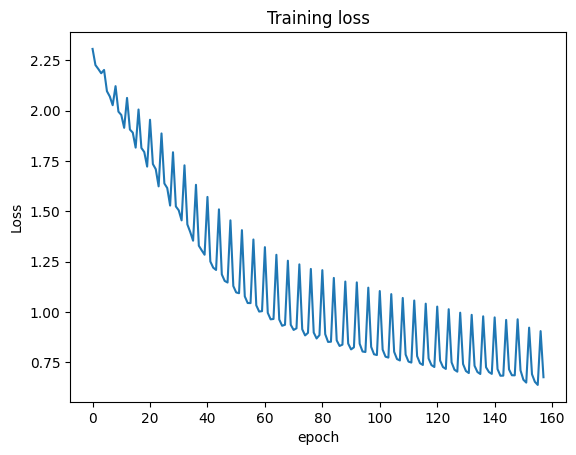

Layers:  180 2 180
Training Model on cpu
Epoch 0 out of 40. Loss:2.3463463187217712
Epoch 4 out of 40. Loss:1.7243432700634003
Epoch 8 out of 40. Loss:1.2848109006881714
Epoch 12 out of 40. Loss:1.0549893826246262
Epoch 16 out of 40. Loss:0.9500934034585953
Epoch 20 out of 40. Loss:0.8993216454982758
Epoch 24 out of 40. Loss:0.8769497945904732
Epoch 28 out of 40. Loss:0.8575885966420174
Epoch 32 out of 40. Loss:0.8459669500589371
Epoch 36 out of 40. Loss:0.8368921130895615


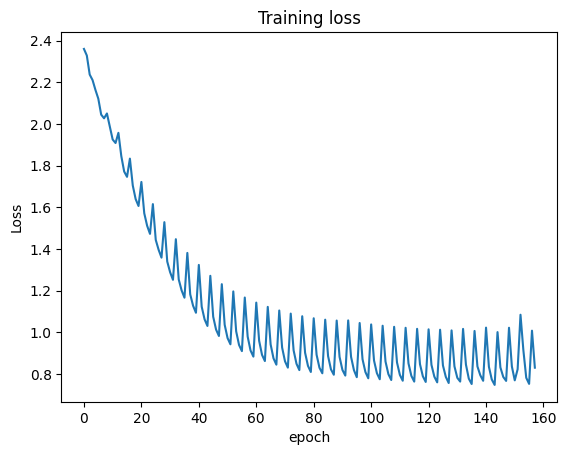

Layers:  220 2 220
Training Model on cpu
Epoch 0 out of 40. Loss:2.354387879371643
Epoch 4 out of 40. Loss:1.7276546359062195
Epoch 8 out of 40. Loss:1.2472708225250244
Epoch 12 out of 40. Loss:1.031153030693531
Epoch 16 out of 40. Loss:0.9402507655322552
Epoch 20 out of 40. Loss:0.8520958162844181
Epoch 24 out of 40. Loss:0.8036741875112057
Epoch 28 out of 40. Loss:0.7561332173645496
Epoch 32 out of 40. Loss:0.7396295331418514
Epoch 36 out of 40. Loss:0.7544798869639635


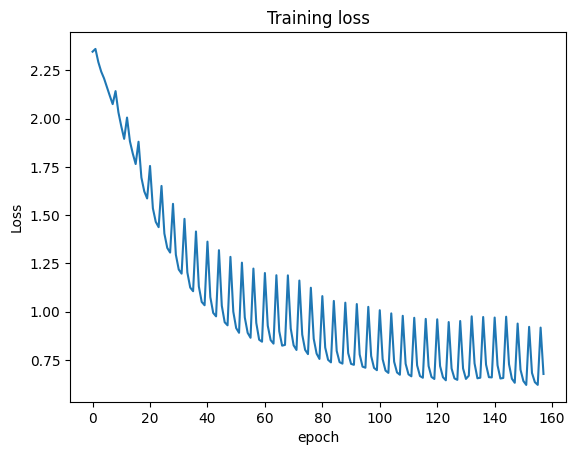

In [32]:
class_models=[]
for n in range(20, 260, 40):
    print("Layers: ", n, 2, n)
    classification_model = train_classifier(
        X_train = X_label,
        Y_train = Y_label,
        hidden = [n, 2, n],
        epochs = 40,
        activation = 'Tanh'
    )
    class_models.append(classification_model)

Here we record the test error for each model

In [33]:
NNN_errors=[]
for model in class_models:
    #For each model we predict the y value
    y_pred = model(torch.tensor(X_test, dtype=torch.float32))
    #We convert predicted value to different labels
    y_pred_labels = torch.argmax(y_pred, dim=1)
    #Calculate error
    error = (y_pred_labels != torch.tensor(Y_test, dtype=torch.long)).float().mean().item()

    NNN_errors.append(error)

V Build augmented self-taught networks using the models learnt in Step II.

For each model:

1) Add the output of the middle layer of an autoencoder as extra features to the original
feature set;

2) Train a new 3-layer Neural Network using all features (original + extra) and varying the
number of hidden neurons (like Step IV) as well.

3) Then calculate and record the test error.
For example, each model should be developed as follows: Model 1: 20 hidden neurons + extra
20 features (from an autoencoder), Model 2: 60 hidden neurons + extra 60 features (from an
autoencoder), ..., Model 5: 220 hidden neurons + extra 220 features (from an autoencoder).


20 hidden neurons + extra features 20
Training Model on cpu
Epoch 0 out of 40. Loss:2.254883825778961
Epoch 4 out of 40. Loss:2.0696389079093933
Epoch 8 out of 40. Loss:1.9717313647270203
Epoch 12 out of 40. Loss:1.8668555319309235
Epoch 16 out of 40. Loss:1.7647680342197418
Epoch 20 out of 40. Loss:1.665860116481781
Epoch 24 out of 40. Loss:1.5749662816524506
Epoch 28 out of 40. Loss:1.4942586421966553
Epoch 32 out of 40. Loss:1.4218372106552124
Epoch 36 out of 40. Loss:1.3566294610500336


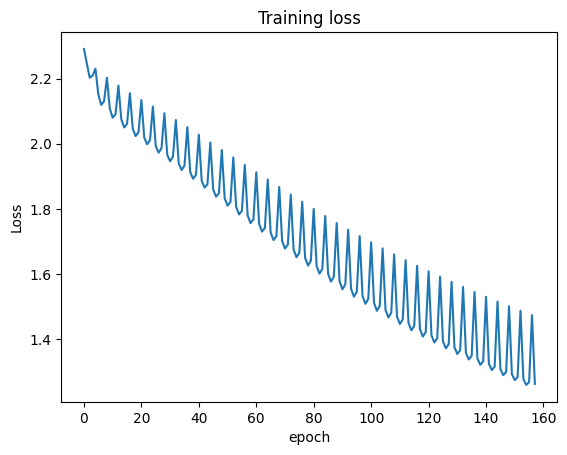

60 hidden neurons + extra features 60
Training Model on cpu
Epoch 0 out of 40. Loss:2.364152193069458
Epoch 4 out of 40. Loss:2.053853362798691
Epoch 8 out of 40. Loss:1.7915718257427216
Epoch 12 out of 40. Loss:1.5674723386764526
Epoch 16 out of 40. Loss:1.3936852812767029
Epoch 20 out of 40. Loss:1.2691236287355423
Epoch 24 out of 40. Loss:1.1801474392414093
Epoch 28 out of 40. Loss:1.1148765683174133
Epoch 32 out of 40. Loss:1.0657813847064972
Epoch 36 out of 40. Loss:1.0281014144420624


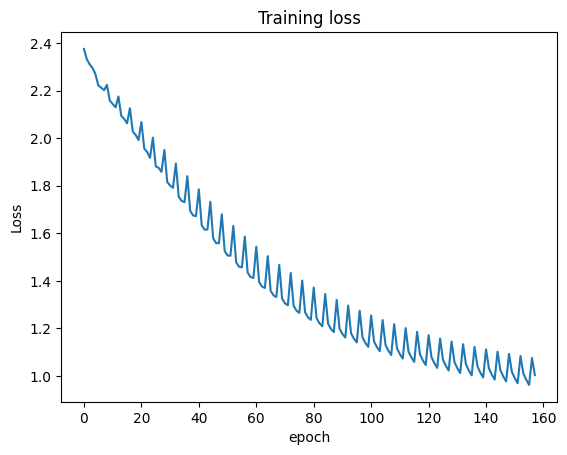

100 hidden neurons + extra features 100
Training Model on cpu
Epoch 0 out of 40. Loss:2.3274423480033875
Epoch 4 out of 40. Loss:1.8949030935764313
Epoch 8 out of 40. Loss:1.610581248998642
Epoch 12 out of 40. Loss:1.3743924796581268
Epoch 16 out of 40. Loss:1.1944689452648163
Epoch 20 out of 40. Loss:1.0781981647014618
Epoch 24 out of 40. Loss:0.9917112588882446
Epoch 28 out of 40. Loss:0.937111884355545
Epoch 32 out of 40. Loss:0.8973456621170044
Epoch 36 out of 40. Loss:0.8704931735992432


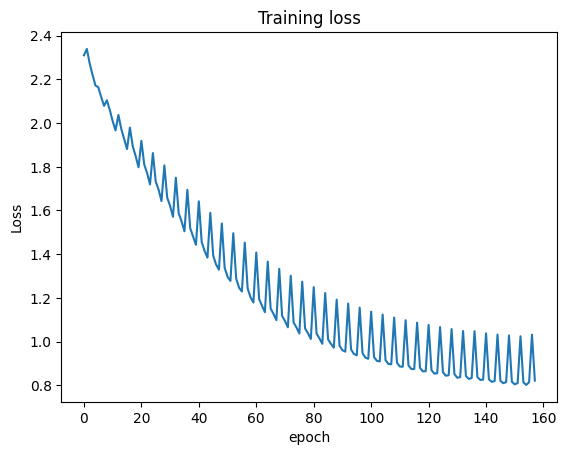

140 hidden neurons + extra features 140
Training Model on cpu
Epoch 0 out of 40. Loss:2.2395198345184326
Epoch 4 out of 40. Loss:1.743944376707077
Epoch 8 out of 40. Loss:1.4231989681720734
Epoch 12 out of 40. Loss:1.2134845405817032
Epoch 16 out of 40. Loss:1.0885916650295258
Epoch 20 out of 40. Loss:1.0158544480800629
Epoch 24 out of 40. Loss:0.9886348247528076
Epoch 28 out of 40. Loss:0.9173656329512596
Epoch 32 out of 40. Loss:0.8820587024092674
Epoch 36 out of 40. Loss:0.810431532561779


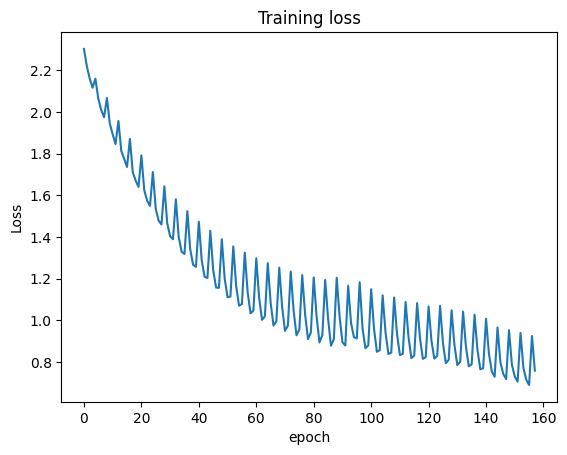

180 hidden neurons + extra features 180
Training Model on cpu
Epoch 0 out of 40. Loss:2.2131962180137634
Epoch 4 out of 40. Loss:1.7502456307411194
Epoch 8 out of 40. Loss:1.4294707477092743
Epoch 12 out of 40. Loss:1.20921890437603
Epoch 16 out of 40. Loss:1.0604361295700073
Epoch 20 out of 40. Loss:0.9705255776643753
Epoch 24 out of 40. Loss:0.8720233589410782
Epoch 28 out of 40. Loss:0.8063249662518501
Epoch 32 out of 40. Loss:0.7650441750884056
Epoch 36 out of 40. Loss:0.71668541431427


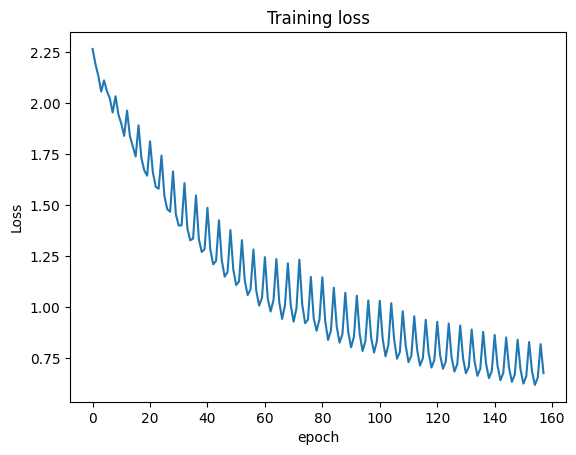

220 hidden neurons + extra features 220
Training Model on cpu
Epoch 0 out of 40. Loss:2.293980598449707
Epoch 4 out of 40. Loss:1.8189677596092224
Epoch 8 out of 40. Loss:1.576206237077713
Epoch 12 out of 40. Loss:1.274213045835495
Epoch 16 out of 40. Loss:1.038350448012352
Epoch 20 out of 40. Loss:0.9007454290986061
Epoch 24 out of 40. Loss:0.8425053954124451
Epoch 28 out of 40. Loss:0.8056618608534336
Epoch 32 out of 40. Loss:0.7738500218838453
Epoch 36 out of 40. Loss:0.7523088473826647


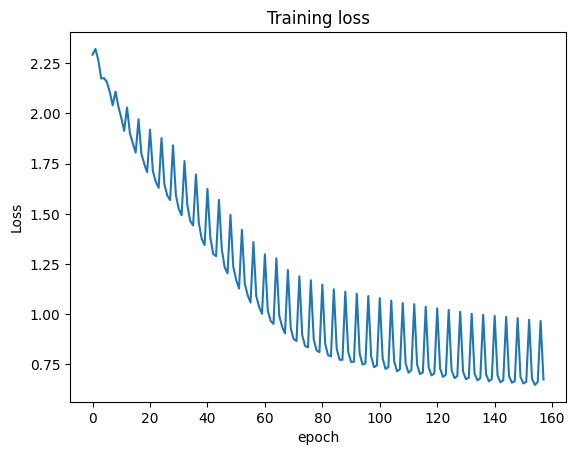

In [42]:
#1: Add the output of the middle layer of an autoencoder as extra features to the original feature set;

#Get the features using deepfeatures from the helperfunctions
extra_features_list = []
for model in autoencodermodellistlabel:
    extra_features = get_deepfeatures(model, X_label, 1)
    extra_features_list.append(extra_features)

#Update the X_label and add the extrafeatures from autoencoder
updated_X_label_list = []
for extra_features in extra_features_list:
    #hstack horizontally arranges the arrays
    updated_X_label = np.hstack((X_label, extra_features))
    updated_X_label_list.append(updated_X_label)

#2: Train a new 3-layer Neural Network using all features (original + extra)
# and varying the hidden network
# We train new models with all features
new_class_models = []
for i, augmented_X in enumerate(updated_X_label_list):
    print(f"{neuron_list[i]} hidden neurons + extra features {neuron_list[i]}")
    classification_model = train_classifier(
        X_train = augmented_X,
        Y_train = Y_label,
        hidden = [neuron_list[i], 2, neuron_list[i]],
        epochs = 40,
        activation = 'Tanh'
    )
    new_class_models.append(classification_model)

In [44]:
# Here we will do the exact same step as above for test. This is
# so that additional features added from autoencoder does not cause mismatch in
#shape
extra_features_test_list = []
for model in autoencodermodellistlabel:
    extra_features_test = get_deepfeatures(model, X_test, 1)
    extra_features_test_list.append(extra_features_test)

updated_X_test_list = []
for extra_features_test in extra_features_test_list:
    updated_X_test = np.hstack((X_test, extra_features_test))
    updated_X_test_list.append(updated_X_test)

allfeatures_errors = []
for i, model in enumerate(new_class_models):
    augmented_X_test = updated_X_test_list[i]
    y_pred = model(torch.tensor(augmented_X_test, dtype=torch.float32))
    y_pred_labels = torch.argmax(y_pred, dim=1)
    error = (y_pred_labels != torch.tensor(Y_test, dtype=torch.long)).float().mean().item()
    allfeatures_errors.append(error)


VI Plot the error rates for the 3-layer neural networks from Step IV and the augmented selftaught networks from Step V, while the x-axis is the number of hidden neurons and y-axis is
the classification error. Explain how the performance of the 3-layer neural networks and the
augmented self-taught networks is different and why they are different or why they are not
different, based on the plot.

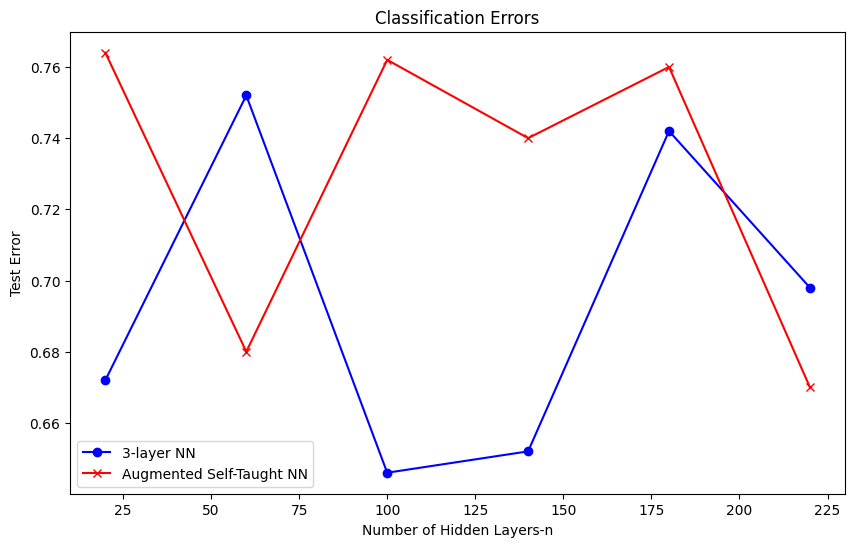

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(neuron_list, NNN_errors, marker='o',label='3-layer NN', color='blue')
plt.plot(neuron_list, allfeatures_errors, marker='x', label='Augmented Self-Taught NN', color='red')
plt.title('Classification Errors')
plt.xlabel('Number of Hidden Layers-n')
plt.ylabel('Test Error')
plt.legend()
plt.show()

Here we can see that the error rate remains pretty high. This means that we have made the model too complex. Looking at the test errot we can see that 3 layer NN does a better job in terms of test errors and reaches its lowest at 100 hidden layer.This trend fluctuate throughoutand eventually is moving to a downward tren as the Neuron Crosses the 180 mark. Looking at the test errors for this we canconclude that autoencoder features has not learned as many useful features. Original features gave pretty much the same result which we can see observing the 3 layer NN.